In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 141.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 60.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 126.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 60.8 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 133.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 120.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-n

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 171.5 MB/s eta 0:00:00


# Analysis of clusters in sample S3

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.ClusterDE as cd

import importlib

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")


/tmp/ipykernel_1236644/1438410382.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)


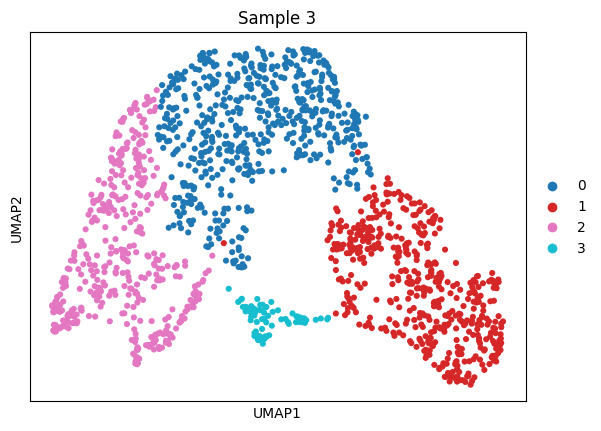

In [5]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Initial DE testing: Wilcoxon rank-sum for every cluster against all others

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


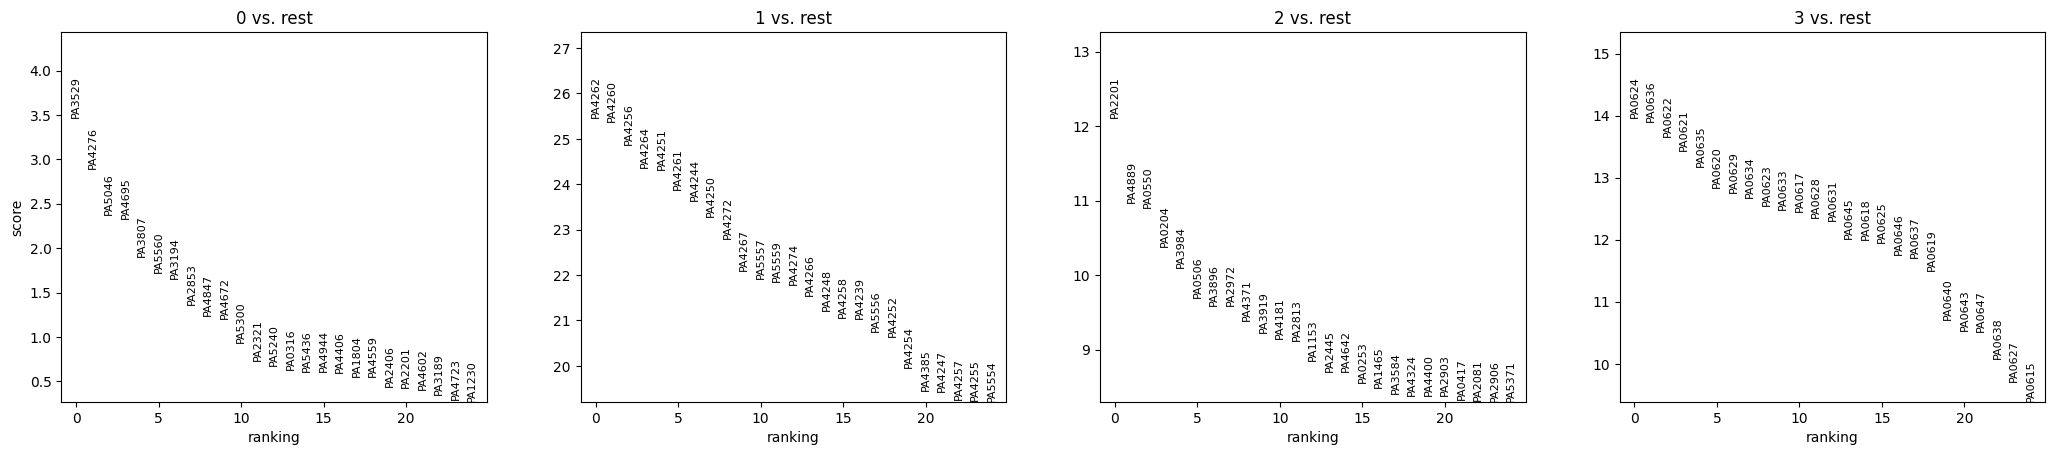

In [6]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [7]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB a

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 900
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB

Both NB and ZINB not converged! Using NB without starting params
gene 1600
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 1700
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both 

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 2700
Both NB and ZIN

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 3400
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 3500
Both NB and ZINB not converged! Using NB without starting params
Both 

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 4500
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZIN

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 5500
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params


## Find optimal correlation matrix scaling and generate synthetic null data

In [8]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

Factor: 1 - Error: 329.26586581126946
Factor: 2 - Error: 348.98678379806006
Factor: -0.618034 - Error: 432.57501800765965
Factor: 1 - Error: 329.26586581126946
Factor: 0.38196600897566 - Error: 424.5779139738081
Factor: 1.38196601 - Error: 316.86066839922955
Factor: 1.6180339872046798 - Error: 336.8771506262865
Factor: 1.2360679772046799 - Error: 308.8979588166468
Factor: 1.1458980338630373 - Error: 316.4642660091514
Factor: 1.2917960666583574 - Error: 311.583137073092
Factor: 1.2016261237245467 - Error: 318.2716562592922
Factor: 1.2573542131782243 - Error: 310.23518056468464
Factor: 1.2229123598538687 - Error: 319.4144626200746
Factor: 1.244198595827413 - Error: 309.7746641836903
Factor: 1.2310429785361037 - Error: 308.7934774458895
Factor: 1.2279373585592188 - Error: 308.63644299851427
Factor: 1.2260179798534812 - Error: 308.0922619858523
Factor: 1.224831738573653 - Error: 318.76644396331
Factor: 1.2267511172793908 - Error: 308.13491228483923
Factor: 1.2255648760049278 - Error: 318.9

In [9]:
importlib.reload(cd)

data_gen_noscale, R_est_noscale = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True, corr_factor=1,
                                                  R_est=None, check_pd=True)


xmin = 1.2360679772046799

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [10]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [11]:
data_gene.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,outlier,n_genes,total_counts_norm,total_counts_scale,embedding_reliability,reliability_score,null_reliability_score,leiden_opt
AAACCCAGTGGACCTC-1,395,5.981414,485.0,6.186209,False,395,-5520.855399,-306.783556,trustworthy,0.556917,0.082263,0
AAACCCATCCTGTAGA-1,558,6.326149,863.0,6.761573,False,558,-5537.830350,-352.602239,trustworthy,0.779740,0.377085,1
AAACGCTCAGATTTCG-1,398,5.988961,491.0,6.198479,False,398,-5514.955366,-275.321721,undefined,0.428113,0.189363,0
AAACGCTTCTTTGCTA-1,598,6.395262,1013.0,6.921658,False,598,-5551.147550,-392.325843,trustworthy,0.619388,0.313508,1
AAAGAACCAGTCTGGC-1,897,6.800170,1190.0,7.082549,False,897,-5367.476470,331.842451,undefined,0.435914,0.547812,2
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGATCTCCTCGCAT-1,592,6.385194,924.0,6.829794,False,592,-5548.655895,-368.312233,trustworthy,0.587962,0.109356,1
TTTGGAGCACCGAATT-1,1930,7.565793,5446.0,8.602820,False,1930,-5396.344149,145.205548,undefined,0.094703,0.589108,1
TTTGGAGCAGCAGTTT-1,604,6.405228,748.0,6.618739,False,604,-5441.733687,59.660240,trustworthy,0.605096,0.301052,2
TTTGGTTTCGTTGTGA-1,371,5.918894,470.0,6.154858,False,371,-5557.570027,-420.193534,undefined,0.427874,0.405871,1


In [12]:
data_null_gen.layers["counts"] = data_null_gen.X.copy()


In [13]:
sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [14]:
data_null_gen.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts
AAACCCAGTGGACCTC-1,1259,7.138867,2650.0,7.882692
AAACCCATCCTGTAGA-1,1493,7.309212,2947.0,7.988882
AAACGCTCAGATTTCG-1,526,6.267201,911.0,6.815640
AAACGCTTCTTTGCTA-1,545,6.302619,797.0,6.682109
AAAGAACCAGTCTGGC-1,932,6.838405,1450.0,7.280008
...,...,...,...,...
TTTGATCTCCTCGCAT-1,1014,6.922644,1744.0,7.464510
TTTGGAGCACCGAATT-1,709,6.565265,918.0,6.823286
TTTGGAGCAGCAGTTT-1,443,6.095825,542.0,6.297109
TTTGGTTTCGTTGTGA-1,865,6.763885,1406.0,7.249215


In [15]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

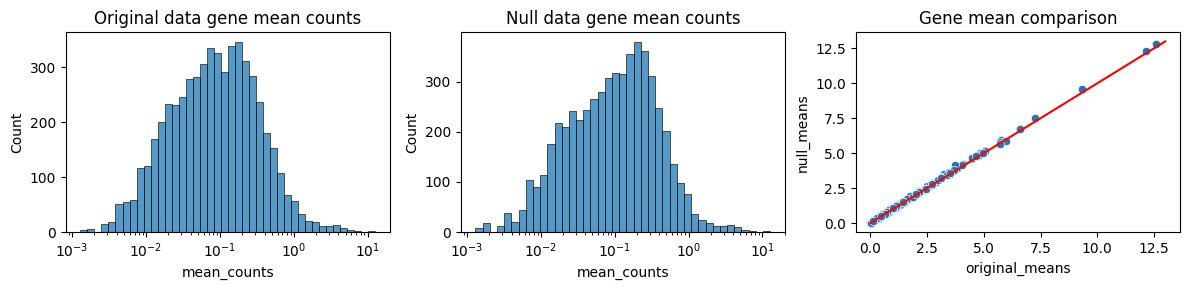

SignificanceResult(statistic=0.9968233661273043, pvalue=0.0)


In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

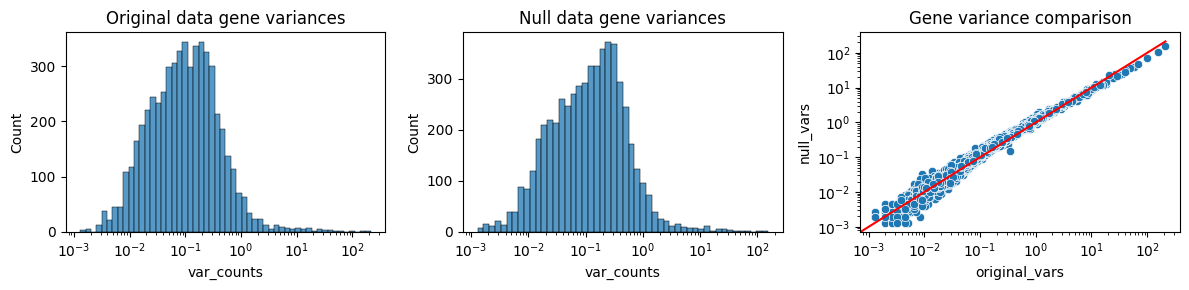

SignificanceResult(statistic=0.9946144943316074, pvalue=0.0)
[[1.         0.99531564]
 [0.99531564 1.        ]]


In [17]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

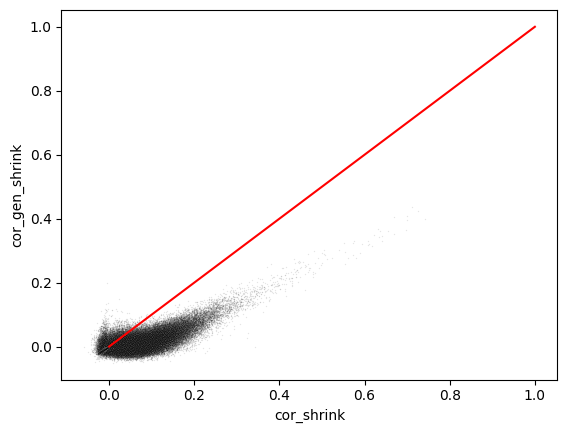

In [18]:
cor_orig = spearmanr(data_gene_nonzero.layers["counts"].toarray()).statistic
cor_orig = pd.DataFrame(cor_orig, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen = spearmanr(data_null_gen.X).statistic
cor_gen = pd.DataFrame(cor_gen, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})
all_cors["ratio"] = all_cors["cor_orig"]/all_cors["cor_gen"]

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1, color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

### Process null data

In [19]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


Index(['Intercept_sct', 'log_umi_sct', 'theta_sct', 'is_scd_outlier_sct',
       'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct',
       'genes_step1_sct', 'log10_gmean_sct', 'is_scd_outlier'],
      dtype='object')


In [20]:
data_null_gen.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,var_counts,is_scd_outlier,nb_overdisp,nb_overdisp_cutoff,nb_mean,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,mean,std
PAO1_ID,,,,,,,,,,,,,,,,,
PA0001,729,0.712435,0.537916,52.784974,1100.0,7.003974,0.886218,False,6.025349,6.025349,-8.549077,2.641371,-8.925563,2.754419,0.017341,0.686256,0.336972
PA0002,555,0.523964,0.421315,64.054404,809.0,6.697034,0.732586,False,4.516780,4.516780,-8.477970,2.509883,NaN,NaN,NaN,0.371274,0.373785
PA0003,832,0.913212,0.648784,46.113990,1410.0,7.252054,1.197131,False,6.461122,6.461122,-8.525667,2.712078,NaN,NaN,NaN,0.806384,0.349541
PA0004,478,0.400907,0.337120,69.041451,619.0,6.429719,0.465569,False,3.373274,3.373274,-8.366846,2.400234,NaN,NaN,NaN,0.073274,0.400572
PA0005,203,0.141192,0.132073,86.852332,218.0,5.389072,0.141982,False,0.919517,0.919517,-7.143886,1.686806,NaN,NaN,NaN,-1.256219,0.570860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,18,0.012306,0.012231,98.834197,19.0,2.995732,0.013450,False,0.097267,0.097267,-5.725379,0.425160,NaN,NaN,NaN,-3.673247,0.405764
PA5567,180,0.147668,0.137732,88.341969,228.0,5.433722,0.197106,False,0.895664,0.895664,-7.112276,1.669385,NaN,NaN,NaN,-1.295596,0.573908
PA5568,700,0.642487,0.496212,54.663212,992.0,6.900731,0.703791,False,5.716880,5.716880,-8.542170,2.612204,NaN,NaN,NaN,0.631391,0.345457


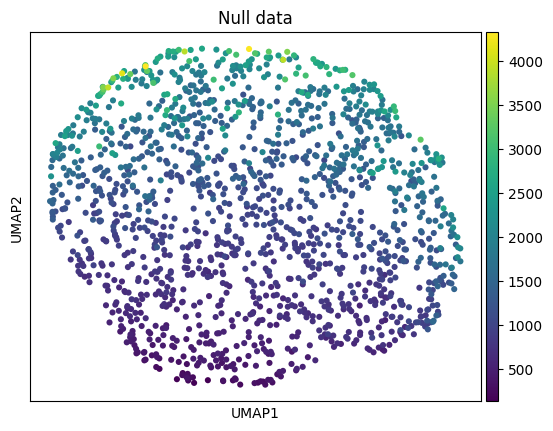

In [21]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [22]:
rng = np.random.default_rng(1234)
seeds = np.random.choice(1000, 100)
print(seeds)

for s in seeds:
    res2 = 0.01
    twoclust = False
    
    while twoclust is False:
        res2 += 0.005
        res2 = np.round(res2, 3)
        sc.tl.leiden(data_null_gen, resolution=res2, key_added=f"leiden_{s}", random_state=s)
        nclust = len(data_null_gen.obs[f"leiden_{s}"].unique())
        if nclust == 2:
            twoclust = True
            

            
            
    
    

[ 76 186 596 529 931 169  24 620 821 629 702 925 236 437 729 496 434 666
  24 419 729 683 961 610 879 683 526 428 546 983 252  73   5 678 588 480
 216 688 333 714 492 632 449 776 886  74 636 866 755 841 223 535 447 977
 273 238 856 625 770 143 403 396 534 344  72 977 352  97 920 972 908 903
 109 696 615 958 702 152  36 832 338 228 896 619  34 954 354 363 260 612
 287 423 466 639 270 690 310 834 737 850]


In [103]:
from scipy.stats import mannwhitneyu

importlib.reload(cd)
clusters = data_gene.obs["leiden_opt"].unique()
all_pvals = {}

i = 0
for s in seeds:
    print("")
    print(s)
    X_null_gen_0 = data_null_gen.X[data_null_gen.obs[f"leiden_{s}"] == "0"]
    X_null_gen_1 = data_null_gen.X[data_null_gen.obs[f"leiden_{s}"] != "0"]
    
    pval_null_gen = pd.DataFrame({"pval_null": mannwhitneyu(X_null_gen_0, X_null_gen_1, alternative="two-sided", method="asymptotic").pvalue}, index=data_null_gen.var.index)
    
    
    DEs_log = {}
    pvals_log = {}
    fdr = 0.05
    
    for c in clusters:
        X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
        X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
        p_data = pd.DataFrame({"pval_data": mannwhitneyu(X_data_0, X_data_1, alternative="two-sided", method="asymptotic").pvalue}, index=data_gene_nonzero.var.index)
        DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
        data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
        data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
        data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
        
        DEs_log[c] = DE_TU
        pvals_log[c] = pval_TU
        print(f"Cluster {c} - DE genes: {len(DEs_log[c])}; Minimum q value: {np.min(pvals_log[c]['q'])}")
        
    all_pvals[i] = pvals_log
    i += 1


76
Cluster 0 - DE genes: 0; Minimum q value: 0.2627707396812423
Cluster 1 - DE genes: 49; Minimum q value: 0.022727272727272728
Cluster 2 - DE genes: 5055; Minimum q value: 0.013125911521633447
Cluster 3 - DE genes: 0; Minimum q value: 1.0

186
Cluster 0 - DE genes: 0; Minimum q value: 0.16362159967519285
Cluster 1 - DE genes: 0; Minimum q value: 0.06666666666666667
Cluster 2 - DE genes: 5035; Minimum q value: 0.024452658515780493
Cluster 3 - DE genes: 0; Minimum q value: 1.0

596
Cluster 0 - DE genes: 0; Minimum q value: 0.11052815669814621
Cluster 1 - DE genes: 0; Minimum q value: 0.07142857142857142
Cluster 2 - DE genes: 4952; Minimum q value: 0.031137184115523464
Cluster 3 - DE genes: 0; Minimum q value: 1.0

529
Cluster 0 - DE genes: 0; Minimum q value: 0.09976002742543709
Cluster 1 - DE genes: 0; Minimum q value: 0.1
Cluster 2 - DE genes: 4844; Minimum q value: 0.03598400710795202
Cluster 3 - DE genes: 0; Minimum q value: 1.0

931
Cluster 0 - DE genes: 0; Minimum q value: 0.1014

Cluster 2 - DE genes: 51; Minimum q value: 0.024390243902439025
Cluster 3 - DE genes: 30; Minimum q value: 0.03333333333333333

480
Cluster 0 - DE genes: 0; Minimum q value: 0.5613224315677213
Cluster 1 - DE genes: 61; Minimum q value: 0.02127659574468085
Cluster 2 - DE genes: 4544; Minimum q value: 0.012448132780082987
Cluster 3 - DE genes: 24; Minimum q value: 0.041666666666666664

216
Cluster 0 - DE genes: 0; Minimum q value: 0.5510484702646957
Cluster 1 - DE genes: 52; Minimum q value: 0.019230769230769232
Cluster 2 - DE genes: 4606; Minimum q value: 0.013447432762836185
Cluster 3 - DE genes: 24; Minimum q value: 0.041666666666666664

688
Cluster 0 - DE genes: 0; Minimum q value: 0.581958195819582
Cluster 1 - DE genes: 64; Minimum q value: 0.020833333333333332
Cluster 2 - DE genes: 4292; Minimum q value: 0.014227642276422764
Cluster 3 - DE genes: 25; Minimum q value: 0.04

333
Cluster 0 - DE genes: 0; Minimum q value: 0.19840319361277445
Cluster 1 - DE genes: 26; Minimum q value: 0

Cluster 3 - DE genes: 0; Minimum q value: 0.933671620152229

972
Cluster 0 - DE genes: 0; Minimum q value: 0.34658073755818114
Cluster 1 - DE genes: 50; Minimum q value: 0.038461538461538464
Cluster 2 - DE genes: 5081; Minimum q value: 0.005291005291005291
Cluster 3 - DE genes: 0; Minimum q value: 0.75

908
Cluster 0 - DE genes: 0; Minimum q value: 0.11175198269646719
Cluster 1 - DE genes: 0; Minimum q value: 0.07692307692307693
Cluster 2 - DE genes: 4947; Minimum q value: 0.033102766798418976
Cluster 3 - DE genes: 0; Minimum q value: 1.0

903
Cluster 0 - DE genes: 0; Minimum q value: 0.18735992828328105
Cluster 1 - DE genes: 0; Minimum q value: 0.05263157894736842
Cluster 2 - DE genes: 5091; Minimum q value: 0.02335299901671583
Cluster 3 - DE genes: 0; Minimum q value: 1.0

109
Cluster 0 - DE genes: 0; Minimum q value: 0.09854014598540146
Cluster 1 - DE genes: 0; Minimum q value: 0.1
Cluster 2 - DE genes: 4882; Minimum q value: 0.03342963268675196
Cluster 3 - DE genes: 0; Minimum q va

In [104]:
for i in range(len(seeds)):
    for c in clusters:
        all_pvals[i][c]["run_no"] = i
    
all_pvals_dfs = {}
for c in clusters:
    all_pvals_dfs[c] = pd.concat([all_pvals[i][c] for i in range(len(seeds))])


[None]

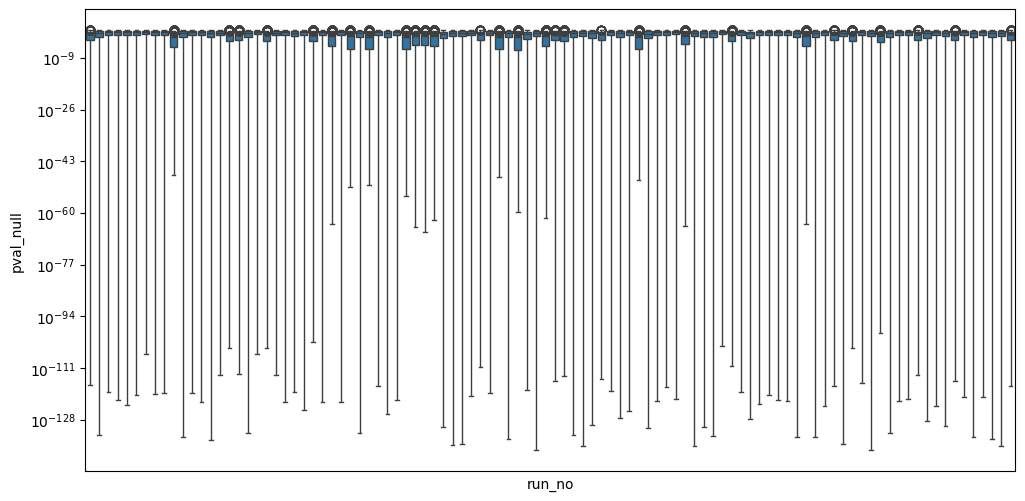

In [105]:
fig, ax = plt.subplots(figsize=(12,6))
g = sns.boxplot(all_pvals_dfs["0"], x="run_no", y="pval_null")
plt.xticks([])
g.set(yscale="log")

In [106]:
for c in clusters:
    all_pvals_dfs[c]["cluster"] = c
    
total_pvals_df = pd.concat(all_pvals_dfs.values())
print(total_pvals_df)

            pval_data      pval_null  pval_trafo_data  pval_trafo_null  \
PAO1_ID                                                                  
PA0631   2.327416e-17   7.724899e-01        16.633126         0.112107   
PA0636   4.022909e-18   9.481660e-02        17.395460         1.023116   
PA0645   7.089138e-17   1.581499e-01        16.149407         0.800931   
PA0623   1.732824e-16   1.114906e-01        15.761246         0.952762   
PA0624   8.675096e-17   1.083189e-02        16.061726         1.965296   
...               ...            ...              ...              ...   
PA4251   5.130758e-01   4.798797e-95         0.289818        94.318868   
PA4256   6.802143e-01  2.270299e-103         0.167354       102.643917   
PA4262   4.800418e-01  2.135462e-107         0.318721       106.670508   
PA4260   7.311233e-01  9.302408e-112         0.136009       111.031405   
PA4264   6.418755e-01  1.039195e-117         0.192549       116.983303   

                 cs         q  run_no

In [107]:
cluster_score_agg = total_pvals_df.reset_index().groupby(["PAO1_ID", "cluster"]).agg({
    "pval_null": ("mean", "median", "min", "max", "var"), 
    "pval_trafo_null": ("mean", "median", "min", "max", "var"),
    "cs": ("mean", "median", "min", "max", "var"), 
    "q": ("mean", "median", "min", "max", "var")
}).reset_index()

In [108]:
cluster_score_agg

PAO1_ID cluster pval_null                                        \
                           mean        median           min       max   
0      PA0001       0  0.039224  4.735190e-04  2.813948e-22  0.687792   
1      PA0001       1  0.039224  4.735190e-04  2.813948e-22  0.687792   
2      PA0001       2  0.039224  4.735190e-04  2.813948e-22  0.687792   
3      PA0001       3  0.039224  4.735190e-04  2.813948e-22  0.687792   
4      PA0002       0  0.022218  4.920648e-06  4.379646e-24  0.672869   
...       ...     ...       ...           ...           ...       ...   
22179  PA5569       3  0.033995  1.992309e-17  2.794319e-40  0.791025   
22180  PA5570       0  0.042836  1.287215e-10  2.154368e-18  0.743130   
22181  PA5570       1  0.042836  1.287215e-10  2.154368e-18  0.743130   
22182  PA5570       2  0.042836  1.287215e-10  2.154368e-18  0.743130   
22183  PA5570       3  0.042836  1.287215e-10  2.154368e-18  0.743130   

                pval_trafo_null                       ...         cs  \
            var            mean     median       min  ...       mean   
0      0.012836        5.278052   3.326772  0.162543  ...  -4.427204   
1      0.012836        5.278052   3.326772  0.162543  ...  -5.076976   
2      0.012836        5.278052   3.326772  0.162543  ...  -2.222331   
3      0.012836        5.278052   3.326772  0.162543  ...  -3.322057   
4      0.010858        7.408752   5.307978  0.172070  ...  -6.953081   
...         ...             ...        ...       ...  ...        ...   
22179  0.018176       17.472195  16.700643  0.101810  ... -16.226205   
22180  0.021169        9.173278   9.890349  0.128935  ...  -1.030043   
22181  0.021169        9.173278   9.890349  0.128935  ...   4.191406   
22182  0.021169        9.173278   9.890349  0.128935  ...  -8.302651   
22183  0.021169        9.173278   9.890349  0.128935  ...  -9.095211   

                                                          q           \
          median        min        max        var      mean   median   
0      -2.475923 -20.699835   0.688305  27.277880  0.956235  1.00000   
1      -3.125695 -21.349608   0.038533  27.277880  0.988757  1.00000   
2      -0.271051 -18.494963   2.893178  27.277880  0.552574  1.00000   
3      -1.370776 -19.594688   1.793453  27.277880  0.997204  1.00000   
4      -4.852306 -22.902890   0.283602  38.344694  0.974000  1.00000   
...          ...        ...        ...        ...       ...      ...   
22179 -15.454653 -38.307734   1.144180  98.297865  1.000000  1.00000   
22180  -1.747115  -9.523446   8.014299  23.559458  0.783609  1.00000   
22181   3.474334  -4.301997  13.235748  23.559458  0.679900  0.66147   
22182  -9.019722 -16.796053   0.741692  23.559458  0.925744  1.00000   
22183  -9.812282 -17.588613  -0.050868  23.559458  1.000000  1.00000   

                                
            min  max       var  
0      0.104716  1.0  0.036786  
1      0.437834  1.0  0.006257  
2      0.038224  1.0  0.228058  
3      0.893353  1.0  0.000266  
4      0.129097  1.0  0.022078  
...         ...  ...       ...  
22179  1.000000  1.0  0.000000  
22180  0.191569  1.0  0.092222  
22181  0.214953  1.0  0.070210  
22182  0.061887  1.0  0.064057  
22183  1.000000  1.0  0.000000  

[22184 rows x 22 columns]

<Axes: xlabel="('cs', 'mean')", ylabel='Count'>

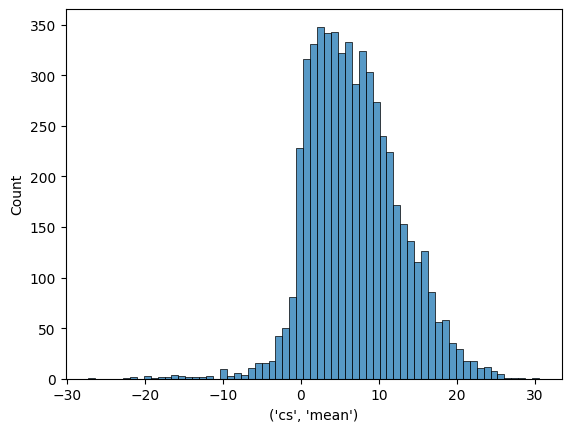

In [109]:
sns.histplot(cluster_score_agg[cluster_score_agg["cluster"] == "2"], x=("cs", "mean"))

[None]

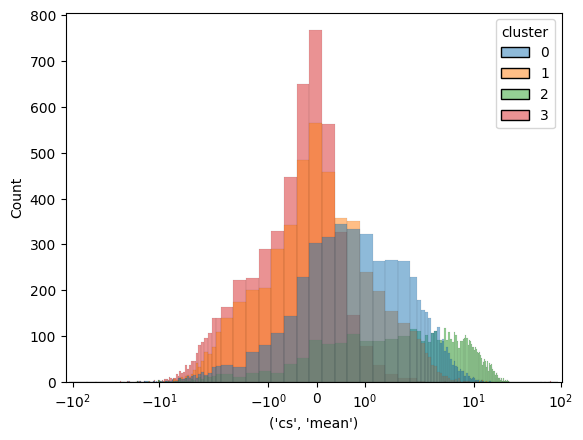

In [110]:
g = sns.histplot(cluster_score_agg, x=("cs", "mean"), hue="cluster")
g.set(xscale="symlog")

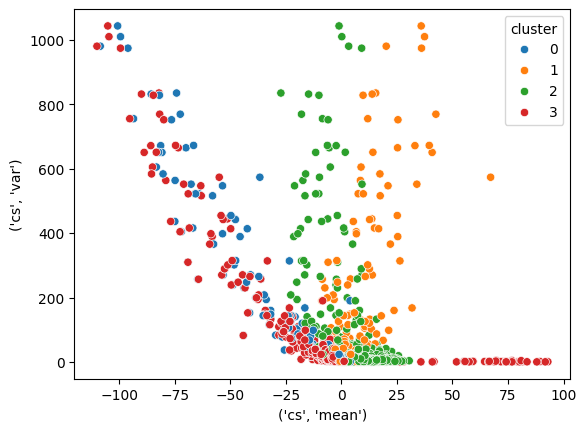

In [111]:
g = sns.scatterplot(cluster_score_agg, x=("cs", "mean"), y=("cs", "var"), hue="cluster")

In [112]:
mean_pvals_null = all_pvals_dfs["0"].reset_index().groupby("PAO1_ID").agg({"pval_null": "mean"})
mean_pvals_null

,pval_null
PAO1_ID,
PA0001,0.039224
PA0002,0.022218
PA0003,0.325242
PA0004,0.136337
PA0005,0.234980
...,...
PA5566,0.512746
PA5567,0.189642
PA5568,0.162413


In [113]:
DEs_log_mean = {}
pvals_log_mean = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, mean_pvals_null, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)

    DEs_log_mean[c] = DE_TU
    pvals_log_mean[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log[c])}; Minimum q value: {np.min(pvals_log[c]['q'])}")



Cluster 0 - DE genes: 0; Minimum q value: 0.2652613087395696
Cluster 1 - DE genes: 47; Minimum q value: 0.02631578947368421
Cluster 2 - DE genes: 5051; Minimum q value: 0.014732965009208104
Cluster 3 - DE genes: 0; Minimum q value: 1.0


In [159]:
pval_table = all_pvals_dfs["0"].reset_index().pivot(columns="PAO1_ID", index="run_no", values="pval_null")
pval_table

PAO1_ID,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
run_no,,,,,,,,,,,,,,,,,,,,,
0,1.106081e-08,3.732448e-11,0.004709,0.002470,0.496394,6.457070e-08,0.473255,0.000080,4.975700e-11,0.726477,...,0.000003,4.625250e-09,0.009259,1.659311e-06,0.000611,0.386468,0.368315,0.356116,3.377172e-09,2.851075e-06
1,1.361186e-04,2.294275e-06,0.179107,0.036241,0.542533,9.806551e-06,0.380670,0.087316,2.222051e-07,0.687841,...,0.000191,7.427565e-06,0.068306,4.793755e-05,0.021090,0.117439,0.167462,0.069179,1.194166e-14,2.920505e-10
2,2.552642e-02,4.174944e-04,0.628924,0.133826,0.040117,2.391050e-02,0.748030,0.333023,2.895288e-04,0.782101,...,0.005607,3.053951e-03,0.035525,2.255105e-02,0.004196,0.916064,0.023620,0.235940,3.944818e-26,5.743799e-13
3,4.641762e-02,3.260304e-03,0.658201,0.459592,0.210606,2.130532e-02,0.334917,0.459174,1.151473e-03,0.968448,...,0.014482,4.897852e-03,0.026533,4.672894e-02,0.026351,0.561729,0.026095,0.069866,2.876812e-28,1.522350e-15
4,4.220383e-02,3.143144e-03,0.809156,0.382728,0.183340,2.447308e-02,0.424569,0.444589,6.838337e-04,0.994221,...,0.009462,4.712843e-03,0.052623,4.773074e-02,0.019102,0.547042,0.020058,0.078289,7.938524e-27,4.478931e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.021268e-03,7.609528e-06,0.429928,0.042247,0.802216,7.356695e-05,0.352783,0.151565,9.740685e-07,0.669378,...,0.000273,1.479966e-04,0.070356,4.046416e-04,0.036359,0.122768,0.110974,0.025894,2.577011e-16,2.250505e-11
96,5.849248e-02,1.899705e-03,0.694370,0.313265,0.247761,5.273501e-02,0.572746,0.561692,1.379819e-03,0.765494,...,0.017190,9.006442e-03,0.050517,4.707436e-02,0.016056,0.841984,0.011372,0.096770,1.395403e-28,3.386274e-15
97,8.917486e-05,7.289192e-06,0.295142,0.057547,0.363898,1.369853e-03,0.497518,0.167953,1.459678e-07,0.870742,...,0.000307,6.172914e-05,0.030766,7.885692e-04,0.005228,0.289323,0.138975,0.017003,2.982318e-20,1.072057e-09


In [171]:
pearson_scores = -2 * np.sum(np.log(1 - pval_table.values), axis=0)
len(pearson_scores)
fisher_scores = 2 * np.sum(np.log(pval_table), axis=0)

In [176]:
from scipy.stats import chi2
fisher_pvals = chi2.cdf(fisher_scores, 2*len(pval_table))

pearson_pvals = chi2.cdf(pearson_scores, 2*len(pval_table))
pearson_pvals

array([0., 0., 0., ..., 0., 0., 0.])

In [178]:
pearson_pval_df = pd.DataFrame({
    "stat_agg": pearson_scores,
    "pval_pearson": pearson_pvals,
    "stat_agg_fisher": fisher_scores,
    "pval_null_fisher": fisher_pvals,
    "pval_comb": np.array([combine_pvalues(pval_table.values[:, i]).pvalue for i in range(len(genes))]),
    "pval_null": np.array([combine_pvalues(pval_table.values[:, i], method="pearson").pvalue for i in range(len(genes))]),
    "stat_comb_p": np.array([combine_pvalues(pval_table.values[:, i], method="pearson").statistic for i in range(len(genes))])

}, index=genes)
pearson_pval_df

,stat_agg,pval_pearson,stat_agg_fisher,pval_null_fisher,pval_comb,pval_null,stat_comb_p
PA0001,-10.432961,0.0,-2430.632857,0.0,0.000000e+00,3.351849e-89,-10.432961
PA0002,-6.461583,0.0,-3411.856368,0.0,0.000000e+00,3.731524e-109,-6.461583
PA0003,-113.676860,0.0,-1066.184462,0.0,3.576091e-118,1.453324e-07,-113.676860
PA0004,-34.904944,0.0,-1314.785265,0.0,3.659400e-163,5.228563e-42,-34.904944
PA0005,-65.352544,0.0,-493.979363,0.0,7.235586e-27,2.697245e-21,-65.352544
...,...,...,...,...,...,...,...
PA5566,-210.978840,0.0,-171.878412,0.0,9.256627e-01,7.164741e-01,-210.978840
PA5567,-53.954131,0.0,-524.047422,0.0,7.157626e-31,3.530820e-27,-53.954131
PA5568,-50.518260,0.0,-697.526108,0.0,2.624003e-56,2.669679e-29,-50.518260
PA5569,-10.427901,0.0,-8046.243299,0.0,0.000000e+00,3.201136e-89,-10.427901


<Axes: xlabel='pval_null', ylabel='Count'>

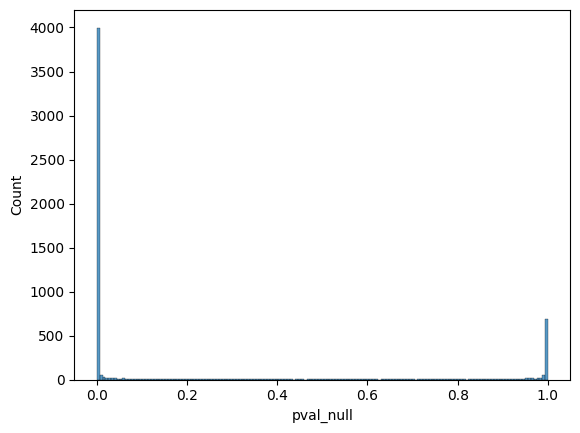

In [179]:
sns.histplot(pearson_pval_df, x="pval_null")

In [182]:
DEs_log_pearson = {}
pvals_log_pearson = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pearson_pval_df, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)

    DEs_log_pearson[c] = DE_TU
    pvals_log_pearson[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log[c])}; Minimum q value: {np.min(pvals_log[c]['q'])}")


Cluster 0 - DE genes: 0; Minimum q value: 0.2652613087395696
Cluster 1 - DE genes: 47; Minimum q value: 0.02631578947368421
Cluster 2 - DE genes: 5051; Minimum q value: 0.014732965009208104
Cluster 3 - DE genes: 0; Minimum q value: 1.0
